### Hackathon pipeline template

In this document an idea of how to create a pipeline.

In [691]:
# general imports
import pandas as pd
import itertools
import numpy as np

# general imports from sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# import for models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# imports for transformation
from sklearn.preprocessing import PolynomialFeatures

# splitting for crossvalidation procedure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# evaluation metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as ev
from sklearn.metrics import r2_score as r2

#plotting tools
import matplotlib.pyplot as plt

import re
from functools import reduce

In [692]:
def clean_column_names(df):
    '''Remove all non letters from the column names'''
    newcols= []
    for colname in df.columns:
        newcols.append(reduce(lambda i,j: i+j,re.findall("[a-zA-Z]",colname)))
    df.columns = newcols
    
    return df

def drop_object_columns(df):
    #remove object types
    dict_type = dict(df.dtypes)

    objectcols=[]
    for key,value in dict_type.items():
        if "object" in str(value):
            objectcols.append(key)

    return df.drop(objectcols,1)

def remove_empty_rows(df,minrows):
    keep=[]
    for i in range(len(data)):
        keep.append(data.loc[i,:].count()>=minrows)
        
    return df[keep]


In [693]:
number_of_locations = 50 #changes depending on how many stations were chosen
filename = 'KNMI_20171122.txt' #Name of the file
y_variable = 'FG' #To predict, wind speed

# import data
# this dataset I retrieved from https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/
data = pd.read_csv(filename,header=47+number_of_locations,sep=',',decimal = ",",na_values = '     ')
data = data.drop(0)
data.index -= 1 #Start at 0

#break down YYYYMMDD column
data["YYYYMMDD"] = data["YYYYMMDD"].astype("str")
data['Year'] = data.YYYYMMDD.apply(lambda x: x[0:4]).astype("int")
data['MM'] = data.YYYYMMDD.apply(lambda x: x[4:6]).astype("int")
data['DD'] = data.YYYYMMDD.apply(lambda x: x[6:8]).astype("int")
data = data.drop("YYYYMMDD",axis=1)

#Remove spaces from headers
data = clean_column_names(data)

print(data.shape)

#Remove completely empty rows
data = remove_empty_rows(data,5)

data.shape

(1012, 43)


(990, 43)

In [694]:
colnames = []
for colname in data.columns:
    data[colname] = data[colname].astype('float')
    colnames.append(colname)

data = data.fillna(data.mean())

data["STN"] = data["STN"].astype("int")

data.head()

,STN,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,...,NG,UG,UX,UXH,UN,UNH,EV,Year,MM,DD
0,209,227.0,79.0,83.0,100.0,17.0,60.0,7.0,120.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,11.0,1.0
1,209,304.0,55.0,60.0,90.0,1.0,30.0,23.0,110.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,11.0,2.0
2,209,182.0,33.0,44.0,70.0,22.0,10.0,2.0,90.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,11.0,3.0
3,209,199.0,44.0,77.0,100.0,17.0,60.0,5.0,150.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,11.0,4.0
4,209,305.0,74.0,82.0,110.0,23.0,30.0,13.0,170.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.0,11.0,5.0


In [695]:
#Fill in missing data with means of the column
mask = np.isnan(data)
masked_df = np.ma.masked_array(data, mask)
means = np.mean(masked_df, axis=0)
data = pd.DataFrame(masked_df.filled(means))
data.columns = colnames

data.head()

,STN,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,...,NG,UG,UX,UXH,UN,UNH,EV,Year,MM,DD
0,209.0,227.0,79.0,83.0,100.0,17.0,60.0,7.0,120.0,11.0,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,1.0
1,209.0,304.0,55.0,60.0,90.0,1.0,30.0,23.0,110.0,1.0,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,2.0
2,209.0,182.0,33.0,44.0,70.0,22.0,10.0,2.0,90.0,23.0,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,3.0
3,209.0,199.0,44.0,77.0,100.0,17.0,60.0,5.0,150.0,23.0,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,4.0
4,209.0,305.0,74.0,82.0,110.0,23.0,30.0,13.0,170.0,23.0,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,5.0


In [696]:
#Add extra features based on location
locationdata = pd.read_csv(filename,header=4,nrows=number_of_locations,sep = r'[ ]{2,}', engine=  'python')

#clean up STN column
clean_column_names(locationdata)
locationdata["STN"] = locationdata["STN"].apply(lambda x: x[2:6])
locationdata = locationdata.drop(locationdata.columns[-1],1)



locationdata.STN = locationdata.STN.apply(lambda x:x[0:-1])
locationdata.STN = locationdata.STN.astype('int')

locationdata = drop_object_columns(locationdata)

locationdata.dtypes

STN           int32
LONeast     float64
LATnorth    float64
ALTm        float64
dtype: object

In [697]:
#Merge location data with other data
data = pd.merge(left = data, right=locationdata, on = "STN")
data = data.drop(['STN'],axis=1)

#Test effect
data = data.drop(['LONeast','LATnorth','ALTm'],1)

data.head()

,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,FXXH,TG,...,NG,UG,UX,UXH,UN,UNH,EV,Year,MM,DD
0,227.0,79.0,83.0,100.0,17.0,60.0,7.0,120.0,11.0,79.885675,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,1.0
1,304.0,55.0,60.0,90.0,1.0,30.0,23.0,110.0,1.0,79.885675,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,2.0
2,182.0,33.0,44.0,70.0,22.0,10.0,2.0,90.0,23.0,79.885675,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,3.0
3,199.0,44.0,77.0,100.0,17.0,60.0,5.0,150.0,23.0,79.885675,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,4.0
4,305.0,74.0,82.0,110.0,23.0,30.0,13.0,170.0,23.0,79.885675,...,6.506849,87.097796,95.426997,9.566116,74.132231,13.016529,4.40176,2017.0,11.0,5.0


In [698]:
# split data in train and test
# continue with train to prevent leakage
train, test = train_test_split(data.index.values,test_size=0.3)
train = data.iloc[train]
test = data.iloc[test]

In [699]:
# create functions for pipeline
class NoTransformation(BaseEstimator, TransformerMixin):
    """ Empty transformer class that allows to skip a step in the pipeline,
    in this case applying no transformation."""
    def __init__(self):
        self = self

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

def build_pipeline(model_name, trans_name, model_dict, trans_dict):

    estimator = Pipeline([
        ('transformation', trans_dict[trans_name]),
        ('classifier', model_dict[model_name])
        ])
    
    return estimator

In [700]:
# do things with train such as make dummies from month and day features\
# you can do this with standard sklearn functions such as OneHotEncoder
# or you can make your own adaptations, create classes and functions like the NoTransformation class above

In [701]:
# make dictionaries with models and transformations you want to apply
# models to apply
model_dict = {
    'lr':LinearRegression(),
    'svr':SVR(),
}

# transformation to apply
trans_dict = {
    'none':NoTransformation(), # simply passes the data
    'poly':PolynomialFeatures(2),
}

In [707]:
# for crosssectional data, use KFold crossvalidation
k_fold = KFold(n_splits=5, random_state=None)

# for timeseries data, use TimeSeriesSplit
#tscv = TimeSeriesSplit(n_splits=5)

In [709]:
evaluation_values = []
i = 0
for train_indices, cv_indices in k_fold.split(train):
    i += 1
    for model_name, trans_name in list(itertools.product(model_dict, trans_dict)):
        estimator = build_pipeline(model_name, trans_name, model_dict, trans_dict)
        estimator.fit(train.drop(y_variable, 1).iloc[train_indices], train[y_variable].iloc[train_indices])
        y_pred = estimator.predict(train.drop(y_variable, 1).iloc[cv_indices])
        evaluation_values.append([i, model_name, trans_name, 
                                  mse(train[y_variable].iloc[cv_indices],y_pred),
                                  mae(train[y_variable].iloc[cv_indices],y_pred),
                                  ev(train[y_variable].iloc[cv_indices],y_pred),
                                  r2(train[y_variable].iloc[cv_indices],y_pred)])

evaluation_values = pd.DataFrame(evaluation_values, columns = ['fold','model','transformation','mse','mae','ev','r2'])
evaluation_values.groupby(['model', 'transformation']).agg('mean').drop('fold', 1)

mse         mae            ev          r2
model transformation                                                     
lr    none                10.733634    2.356034  9.835371e-01    0.983336
      poly            104572.205056  159.164112 -1.571308e+02 -158.095880
svr   none               687.988258   19.565995  3.381853e-04   -0.040116
      poly               688.252463   19.570031  4.440892e-17   -0.040508

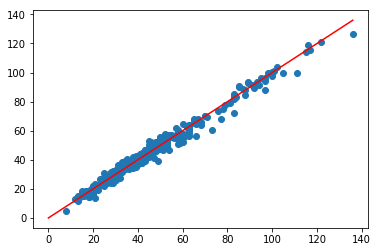

In [712]:
# apply to test set
estimator = build_pipeline('lr', 'none', model_dict, trans_dict)
estimator.fit(train.drop(y_variable, 1), train[y_variable])
y_pred = estimator.predict(test.drop(y_variable, 1))
mae(test[y_variable],y_pred)

#print(list(test[y_variable]))
#print(y_pred)

plt.scatter(list(test[y_variable]),y_pred)
plt.plot([0,max(list(test[y_variable]))],[0,max(list(test[y_variable]))], c='red')

plt.show()